In [1]:
from pybaseball import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import *

import statsmodels.formula.api as smf

from sklearn.metrics import (
    auc,
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_curve,
)

In [2]:
teams = ['MIN','CLE','KCR','CHW','DET', #AL Cenntral
         'TOR','BAL','BOS','TBR','NYY', #AL East
         'OAK','HOU','SEA','LAA','TEX', #AL West
         'ATL','PHI','NYM','WSN','MIA','FLA', #NL East
         'PIT','CIN','CHC','MIL','STL', #NL Central
         'ARI','SDP','SFG','COL','LAD', #NL West
        ]

years = np.arange(2010,2021,1)

full_games = pd.DataFrame()
batting_df = pd.DataFrame()
pitching_df = pd.DataFrame()

for team in teams:
    print('Importing', team)
    for year in years:
        try:
            data = schedule_and_record(year, team)
            data['season'] = year
            full_games = pd.concat([full_games,data])
            
            # game logs for each teams hitters
            batting_logs = team_game_logs(year, team)
            batting_logs['season'] = year
            batting_logs['Tm'] = team
            batting_df = pd.concat([batting_df,batting_logs])
            
            # game logs for each teams pitching
            #should eventually be replaced by starter level data
            pitching_logs = team_game_logs(year, team, 'pitching')
            pitching_logs['season'] = year
            pitching_logs['Tm'] = team
            pitching_df = pd.concat([pitching_df,pitching_logs])
        except:
            continue
            
print('\nAll Teams Imported')

Importing MIN
Importing CLE
Importing KCR
Importing CHW
Importing DET
Importing TOR
Importing BAL
Importing BOS
Importing TBR
Importing NYY
Importing OAK
Importing HOU
Importing SEA
Importing LAA
Importing TEX
Importing ATL
Importing PHI
Importing NYM
Importing WSN
Importing MIA
Importing FLA
Importing PIT
Importing CIN
Importing CHC
Importing MIL
Importing STL
Importing ARI
Importing SDP
Importing SFG
Importing COL
Importing LAD

All Teams Imported


In [3]:
full_games['month'] = full_games['Date'].replace(to_replace = ['Mar','Apr','May',"Jun","Jul",'Aug'
                                                  ,'Sep',"Oct",'Nov','Dec']
                                              ,value = [3,4,5,6,7,8,9,10,11,12]
                                            ,regex=True)

full_games['clean_date'] = full_games['month'].astype(str)+'/'+full_games['Date'].str[-2:].astype(str).replace(' ','',regex=True) + '/' + full_games['season'].astype(str)



batting_df['month'] = batting_df['Date'].replace(to_replace = ['Mar','Apr','May',"Jun","Jul",'Aug'
                                                  ,'Sep',"Oct",'Nov','Dec']
                                              ,value = [3,4,5,6,7,8,9,10,11,12]
                                            ,regex=True)

batting_df['clean_date'] = batting_df['month'].astype(str)+'/'+batting_df['Date'].str[-2:].astype(str).replace(' ','',regex=True)  + '/' + batting_df['season'].astype(str)


pitching_df['month'] = pitching_df['Date'].replace(to_replace = ['Mar','Apr','May',"Jun","Jul",'Aug'
                                                  ,'Sep',"Oct",'Nov','Dec']
                                              ,value = [3,4,5,6,7,8,9,10,11,12]
                                            ,regex=True)

pitching_df['clean_date'] = pitching_df['month'].astype(str)+'/'+pitching_df['Date'].str[-2:].astype(str).replace(' ','',regex=True)  + '/' + pitching_df['season'].astype(str)

In [4]:
#combined the historic data
comb_df = full_games.merge(batting_df,
                           how = 'left',
                           left_on=['clean_date','Tm'],
                           right_on=['clean_date','Tm'],
                           suffixes=['','_hitting']
                          ).merge(
                            pitching_df,
                           how = 'left',
                           left_on=['clean_date','Tm'],
                           right_on=['clean_date','Tm'],
                           suffixes=['','_pitching']
)

In [5]:
import os
os.chdir('/Users/andrew.green/Downloads/')
odds2010 = pd.read_csv('mlb_odds_2010.csv')
odds2011 = pd.read_csv('mlb_odds_2011.csv')
odds2012 = pd.read_csv('mlb_odds_2012.csv')
odds2013 = pd.read_csv('mlb_odds_2013.csv')
odds2014 = pd.read_csv('mlb_odds_2014.csv')
odds2015 = pd.read_csv('mlb_odds_2015.csv')
odds2016 = pd.read_csv('mlb_odds_2016.csv')
odds2017 = pd.read_csv('mlb_odds_2017.csv')
odds2018 = pd.read_csv('mlb_odds_2018.csv')
odds2019 = pd.read_csv('mlb_odds_2019_2.csv')
odds2020 = pd.read_csv('mlb_odds_2020.csv')

game_odds = pd.concat([odds2010
                      ,odds2011
                      ,odds2012
                      ,odds2013
                      ,odds2014
                      ,odds2015
                      ,odds2016
                      ,odds2017
                      ,odds2018
                      ,odds2019
                      ,odds2020],axis=0)
game_odds = game_odds[['Date','Team','Close']]

#converting the odds to win probabilities
game_odds['implied_odds'] = (abs(game_odds['Close']) / (abs(game_odds['Close']) + 100) ).where(
            game_odds["Close"] <0, (100 / (game_odds['Close'] + 100))
        )

#cleaning csv data to have the same team codes as the team data
#there is 1 game that gets lost in this process
game_odds['Team'] = game_odds['Team'].replace({'SFO':'SFG'
                                               ,'TAM':'TBR'
                                               ,'WAS':'WSN'
                                               ,'KAN':'KCR'
                                               ,'CUB':'CHC'
                                               ,'SDG':'SDP'
                                               ,'CWS':'CHW'
                                               ,'LOS':'LAD'
                                                })
game_odds

,Date,Team,Close,implied_odds
0,4/4/2010,NYY,-103.0,0.507389
1,4/4/2010,BOS,-117.0,0.539171
2,4/5/2010,PHI,-200.0,0.666667
3,4/5/2010,WSN,170.0,0.370370
4,4/5/2010,MIA,-112.0,0.528302
...,...,...,...,...
1895,10/24/2020,TBR,148.0,0.403226
1896,10/25/2020,LAD,-160.0,0.615385
1897,10/25/2020,TBR,150.0,0.400000
1898,10/27/2020,TBR,111.0,0.473934


In [6]:
combined_game_data = comb_df.merge(game_odds,
                              how="left",
                              left_on=[
                                    "Tm",
                                    "clean_date",
                                ],
                                right_on=["Team", "Date"],
                            )
combined_game_data.columns

Index(['Date_x', 'Tm', 'Home_Away', 'Opp', 'W/L', 'R', 'RA', 'Inn', 'W-L',
       'Rank', 'GB', 'Win', 'Loss', 'Save', 'Time', 'D/N', 'Attendance', 'cLI',
       'Streak', 'Orig. Scheduled', 'season', 'month', 'clean_date', 'Game',
       'Date_hitting', 'Home', 'Opp_hitting', 'Rslt', 'PA', 'AB', 'R_hitting',
       'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SH', 'SF',
       'ROE', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'LOB',
       'NumPlayers', 'Thr', 'OppStart', 'season_hitting', 'month_hitting',
       'Game_pitching', 'Date_pitching', 'Home_pitching', 'Opp_pitching',
       'Rslt_pitching', 'IP', 'H_pitching', 'R_pitching', 'ER', 'UER',
       'BB_pitching', 'SO_pitching', 'HR_pitching', 'HBP_pitching', 'ERA',
       'BF', 'Pit', 'Str', 'IR', 'IS', 'SB_pitching', 'CS_pitching',
       'AB_pitching', '2B_pitching', '3B_pitching', 'IBB_pitching',
       'SH_pitching', 'SF_pitching', 'ROE_pitching', 'GDP_pitching',
       'NumPlayers_pitching', 'Umpire', 'Pitch

In [103]:
rolling_fields = ['R'
                  ,'RA'
                  ,'Rank'
                  , 'PA'
                  , 'AB'
                  , 'R_hitting'
                  , 'H'
                  , '2B'
                  , '3B'
                  , 'HR'
                  , 'RBI'
                  , 'BB'
                  , 'IBB'
                  , 'SO'
                  , 'HBP'
                  , 'SH'
                  , 'SF'
                  ,'ROE'
                  , 'GDP'
                  , 'SB'
                  , 'CS'
                  , 'LOB'
                  , 'H_pitching'
                  , 'R_pitching'
                  , 'ER'
                  , 'UER'
                  ,'BB_pitching'
                  , 'SO_pitching'
                  , 'HR_pitching'
                  , 'HBP_pitching'
                  , 'BF'
                  , 'IR'
                  , 'IS'
                  , 'SB_pitching'
                  , 'CS_pitching'
                  , 'AB_pitching'
                  , '2B_pitching'
                  , '3B_pitching'
                  , 'IBB_pitching'
                  , 'SH_pitching'
                  , 'SF_pitching'
                  , 'ROE_pitching'
                  , 'GDP_pitching'
                  , 'IP'
                 ]

for column in combined_game_data:
    if column in rolling_fields:
        combined_game_data[column+'_ROLLING'] = combined_game_data[column
                                                                  ].rolling(min_periods=1
                                                                                   , window=61
                                                                                  ).sum() - combined_game_data[column]
for column in combined_game_data:
    print(column)

Date_x
Tm
Home_Away
Opp
W/L
R
RA
Inn
W-L
Rank
GB
Win
Loss
Save
Time
D/N
Attendance
cLI
Streak
Orig. Scheduled
season
month
clean_date
Game
Date_hitting
Home
Opp_hitting
Rslt
PA
AB
R_hitting
H
2B
3B
HR
RBI
BB
IBB
SO
HBP
SH
SF
ROE
GDP
SB
CS
BA
OBP
SLG
OPS
LOB
NumPlayers
Thr
OppStart
season_hitting
month_hitting
Game_pitching
Date_pitching
Home_pitching
Opp_pitching
Rslt_pitching
IP
H_pitching
R_pitching
ER
UER
BB_pitching
SO_pitching
HR_pitching
HBP_pitching
ERA
BF
Pit
Str
IR
IS
SB_pitching
CS_pitching
AB_pitching
2B_pitching
3B_pitching
IBB_pitching
SH_pitching
SF_pitching
ROE_pitching
GDP_pitching
NumPlayers_pitching
Umpire
PitchersUsed
season_pitching
month_pitching
Date_y
Team
Close
implied_odds
R_ROLLING
RA_ROLLING
Rank_ROLLING
PA_ROLLING
AB_ROLLING
R_hitting_ROLLING
H_ROLLING
2B_ROLLING
3B_ROLLING
HR_ROLLING
RBI_ROLLING
BB_ROLLING
IBB_ROLLING
SO_ROLLING
HBP_ROLLING
SH_ROLLING
SF_ROLLING
ROE_ROLLING
GDP_ROLLING
SB_ROLLING
CS_ROLLING
LOB_ROLLING
IP_ROLLING
H_pitching_ROLLING
R_pitchi

In [104]:
#creating vairables with the lagged data

#stats that are for both hitters and pitchers

#batting average
combined_game_data['BA_FOR'] = combined_game_data['H_ROLLING'] / combined_game_data['AB_ROLLING']
combined_game_data['BA_AGAINST'] = combined_game_data['H_pitching_ROLLING'] / combined_game_data['AB_pitching_ROLLING']

# Walk to Strikeout Ratio
combined_game_data['BB_K_RATIO_FOR'] = combined_game_data['BB_ROLLING'] / combined_game_data['SO_ROLLING']
combined_game_data['BB_K_RATIO_AGAINST'] = combined_game_data['BB_pitching_ROLLING'] / combined_game_data['SO_pitching_ROLLING']

# on base plus slugging, which requires OBP & SLG before summing them together
combined_game_data['OBP_FOR'] = (combined_game_data['H_ROLLING'] + 
                             combined_game_data['BB_ROLLING'] + 
                             combined_game_data['HBP_ROLLING']) / (combined_game_data['SF_ROLLING'] + 
                                                                   combined_game_data['AB_ROLLING'] + 
                                                                   combined_game_data['BB_ROLLING'] + 
                                                                   combined_game_data['HBP_ROLLING'])

combined_game_data['SLG_FOR'] = ((combined_game_data['H_ROLLING'] - 
                                 combined_game_data['HR_ROLLING'] - 
                                 combined_game_data['3B_ROLLING'] - 
                                 combined_game_data['2B_ROLLING']) + 
                                 (2 * combined_game_data['2B_ROLLING']) + 
                                 (3 * combined_game_data['3B_ROLLING']) + 
                                 (4 * combined_game_data['HR_ROLLING']) + 
                                 combined_game_data['BB_ROLLING']) / (combined_game_data['AB_ROLLING'] + 
                                                                     combined_game_data['BB_ROLLING'])

combined_game_data['OPS_FOR'] = combined_game_data['OBP_FOR'] + combined_game_data['SLG_FOR']


combined_game_data['OBP_AGAINST'] = (combined_game_data['H_pitching_ROLLING'] + 
                             combined_game_data['BB_pitching_ROLLING'] + 
                             combined_game_data['HBP_pitching_ROLLING']) / (combined_game_data['SF_pitching_ROLLING'] + 
                                                                   combined_game_data['AB_pitching_ROLLING'] + 
                                                                   combined_game_data['BB_pitching_ROLLING'] + 
                                                                   combined_game_data['HBP_pitching_ROLLING'])

combined_game_data['SLG_AGAINST'] = ((combined_game_data['H_pitching_ROLLING'] - 
                                 combined_game_data['HR_pitching_ROLLING'] - 
                                 combined_game_data['3B_pitching_ROLLING'] - 
                                 combined_game_data['2B_pitching_ROLLING']) + 
                                 (2 * combined_game_data['2B_pitching_ROLLING']) + 
                                 (3 * combined_game_data['3B_pitching_ROLLING']) + 
                                 (4 * combined_game_data['HR_pitching_ROLLING']) + 
                                 combined_game_data['BB_pitching_ROLLING']) / (combined_game_data['AB_pitching_ROLLING'] + 
                                                                     combined_game_data['BB_pitching_ROLLING'])

combined_game_data['OPS_AGAINST'] = combined_game_data['OBP_AGAINST'] + combined_game_data['SLG_AGAINST']

#stolen base %
combined_game_data['SB_PERC_FOR'] = combined_game_data['SB_ROLLING'] / (combined_game_data['SB_ROLLING'] + 
                                                                       combined_game_data['CS_ROLLING'])

combined_game_data['SB_PERC_AGAINST'] = combined_game_data['SB_pitching_ROLLING'] / (combined_game_data['SB_pitching_ROLLING'] + 
                                                                       combined_game_data['CS_pitching_ROLLING'])
#strikeout rate
combined_game_data['K_PERC_FOR'] = combined_game_data['SO_ROLLING'] / (combined_game_data['AB_ROLLING'] + 
                                                                     combined_game_data['BB_ROLLING'])

combined_game_data['K_PERC_AGAINST'] = combined_game_data['SO_pitching_ROLLING'] / (combined_game_data['AB_pitching_ROLLING'] + 
                                                                     combined_game_data['BB_pitching_ROLLING'])


#home_run rate
combined_game_data['HR_PERC_FOR'] = combined_game_data['HR_ROLLING'] / (combined_game_data['AB_ROLLING'] + 
                                                                     combined_game_data['BB_ROLLING'])

combined_game_data['HR_PERC_AGAINST'] = combined_game_data['HR_pitching_ROLLING'] / (combined_game_data['AB_pitching_ROLLING'] + 
                                                                     combined_game_data['BB_pitching_ROLLING'])


In [105]:
#hitter only stats

#ISO
combined_game_data['ISO'] = combined_game_data['SLG_FOR'] - combined_game_data['BA_FOR'] 

#% left on base
# only done for the team because i do not have LOB against
combined_game_data['LOB_PERC_FOR'] = combined_game_data['LOB_ROLLING'] / (combined_game_data['H_ROLLING'] + 
                                                                          combined_game_data['BB_ROLLING'])

In [106]:
#pitcher only stats


#FIP (Fielding Independent Pitching)
combined_game_data['FIP'] = ((combined_game_data['HR_pitching_ROLLING'] * 13) + 
                             (combined_game_data['BB_pitching_ROLLING'] * 33) -
                             (combined_game_data['SO_pitching_ROLLING'] * 2)) / (combined_game_data['IP_ROLLING'])

#WHIP
combined_game_data['WHIP'] = (combined_game_data['BB_pitching_ROLLING'] +
                             combined_game_data['SO_pitching_ROLLING']) / (combined_game_data['IP_ROLLING'])


In [107]:
corr_matrix = pd.DataFrame(combined_game_data.corr()['R'])
corr_matrix['abs_corr'] = abs(corr_matrix['R'])

corr_matrix = corr_matrix.sort_values(by=['abs_corr'], ascending=False)
corr_matrix.head(50)

,R,abs_corr
R,1.000000,1.000000
R_hitting,0.949225,0.949225
RBI,0.938254,0.938254
H,0.729737,0.729737
PA,0.547714,0.547714
HR,0.539020,0.539020
AB,0.456848,0.456848
Streak,0.450276,0.450276
2B,0.424810,0.424810
BB,0.330576,0.330576


                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     316.4
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          3.15e-269
Time:                        20:26:08   Log-Likelihood:            -1.2378e+05
No. Observations:               48752   AIC:                         2.476e+05
Df Residuals:                   48747   BIC:                         2.476e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0195      0.288     -0.

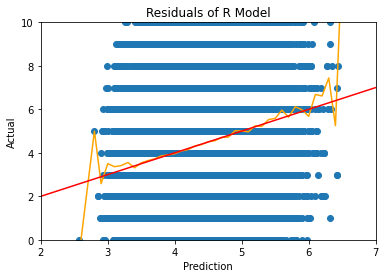

In [108]:
#building the initial hitting model

mod = smf.ols(
    """
        R ~ OPS_FOR
            + implied_odds
            + ISO
            + BB_K_RATIO_FOR


    """,
    data=combined_game_data,
).fit()

print(mod.summary())

combined_game_data['pred'] = mod.predict(combined_game_data)

print('Mean Error =',round(np.mean((combined_game_data['pred'] - combined_game_data['R']) ),2))
print('MAE=',np.mean(round(abs(combined_game_data['pred'] - combined_game_data['R']),2 )))


combined_game_data['rounded_runs'] = round(combined_game_data['pred'],1)
grouped_df = combined_game_data.groupby('rounded_runs').mean().reset_index()


plt.figure()
plt.scatter(x=combined_game_data['pred']
            , y=combined_game_data['R'])
sns.lineplot(x="rounded_runs", y='R', data = grouped_df,color='orange')
plt.plot([-2,30],[-2,30], color='red')
plt.xlim([2,7])
plt.ylim([0,10])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Residuals of R Model')
plt.show()

In [109]:
corr_matrix = pd.DataFrame(combined_game_data.corr()['RA'])
corr_matrix['abs_corr'] = abs(corr_matrix['RA'])

corr_matrix = corr_matrix.sort_values(by=['abs_corr'], ascending=False)
corr_matrix.head(50)

,RA,abs_corr
RA,1.000000,1.000000
R_pitching,0.938901,0.938901
ER,0.907038,0.907038
H_pitching,0.722820,0.722820
BF,0.545029,0.545029
HR_pitching,0.529945,0.529945
AB_pitching,0.457526,0.457526
Streak,-0.448852,0.448852
Pit,0.441957,0.441957
2B_pitching,0.426429,0.426429


                            OLS Regression Results                            
Dep. Variable:                     RA   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     237.1
Date:                Sun, 24 Jan 2021   Prob (F-statistic):          3.31e-201
Time:                        20:26:10   Log-Likelihood:                -87257.
No. Observations:               34363   AIC:                         1.745e+05
Df Residuals:                   34358   BIC:                         1.746e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.7941      0

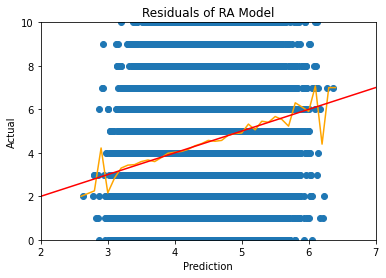

In [110]:
#building the initial hitting model

mod = smf.ols(
    """
        RA ~ implied_odds
            + BB_K_RATIO_AGAINST
            + OPS_AGAINST
            + FIP


    """,
    data=combined_game_data,
).fit()

print(mod.summary())

combined_game_data['pred'] = mod.predict(combined_game_data)

print('Mean Error =',round(np.mean((combined_game_data['pred'] - combined_game_data['RA']) ),2))
print('MAE=',np.mean(round(abs(combined_game_data['pred'] - combined_game_data['RA']),2 )))


combined_game_data['rounded_runs'] = round(combined_game_data['pred'],1)
grouped_df = combined_game_data.groupby('rounded_runs').mean().reset_index()


plt.figure()
plt.scatter(x=combined_game_data['pred']
            , y=combined_game_data['RA'])
sns.lineplot(x="rounded_runs", y='RA', data = grouped_df,color='orange')
plt.plot([-2,30],[-2,30], color='red')
plt.xlim([2,7])
plt.ylim([0,10])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Residuals of RA Model')
plt.show()

In [111]:
def r_model(df, date):
    mod = smf.ols(
    """
        R ~ OPS_FOR
            + implied_odds
            + ISO
            + BB_K_RATIO_FOR


    """,
        data=df.loc[df['Date_y'] < date],
    ).fit()

    r_preds = mod.predict(df.loc[df['Date_y'] == date])
    return r_preds

def ra_model(df, date):
    mod = smf.ols(
    """
        RA ~ implied_odds
            + BB_K_RATIO_AGAINST
            + OPS_AGAINST
            + FIP


        """,
        data=df.loc[df['Date_y'] < date],
    ).fit()

    ra_preds = mod.predict(df.loc[df['Date_y'] == date])
    return ra_preds



In [112]:
#running loop for predictions
dates = combined_game_data['Date_y'].unique()

In [113]:
pred_df = combined_game_data.copy()
pred_df['r_pred'] = np.nan
pred_df['ra_pred'] = np.nan

for d in dates:
    print(d)
    try:
        r_preds = r_model(df=pred_df, date = d)
        ra_preds = ra_model(df=pred_df, date = d)
        pred_df['r_pred'][pred_df['Date_y'] == d] = r_preds
        pred_df['ra_pred'][pred_df['Date_y'] == d] = ra_preds
    except:
        print('skipped')
        continue

4/5/2010
4/6/2010


/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


4/7/2010
4/8/2010
4/9/2010
4/10/2010
4/11/2010
4/12/2010
4/14/2010
4/15/2010
4/16/2010
4/17/2010
4/18/2010
4/20/2010
4/21/2010
4/22/2010
4/23/2010
4/24/2010
4/25/2010
4/27/2010
4/28/2010
4/29/2010
4/30/2010
5/1/2010
5/2/2010
5/3/2010
5/4/2010
5/5/2010
5/6/2010
nan
skipped
5/9/2010
5/11/2010
5/12/2010
5/14/2010
5/15/2010
5/16/2010
5/17/2010
5/18/2010
5/19/2010
5/20/2010
5/21/2010
5/22/2010
5/23/2010
5/25/2010
5/26/2010
5/27/2010
5/28/2010
5/29/2010
5/30/2010
5/31/2010
6/1/2010
6/2/2010
6/3/2010
6/4/2010
6/5/2010
6/6/2010
6/8/2010
6/9/2010
6/10/2010
6/11/2010
6/12/2010
6/13/2010
6/15/2010
6/16/2010
6/17/2010
6/18/2010
6/19/2010
6/20/2010
6/22/2010
6/23/2010
6/24/2010
6/25/2010
6/26/2010
6/27/2010
6/28/2010
6/29/2010
6/30/2010
7/1/2010
7/2/2010
7/3/2010
7/4/2010
7/6/2010
7/7/2010
7/8/2010
7/9/2010
7/10/2010
7/11/2010
7/15/2010
7/16/2010
7/17/2010
7/18/2010
7/19/2010
7/20/2010
7/21/2010
7/22/2010
7/23/2010
7/24/2010
7/25/2010
7/26/2010
7/27/2010
7/28/2010
7/30/2010
7/31/2010
8/1/2010
8/2/2

In [114]:
print(np.mean(pred_df['r_pred']))
print(np.mean(pred_df['ra_pred']))

4.357183245357017
4.397714785969869


In [115]:
#calculate the win % of each team
pred_df['PT'] = (pred_df['r_pred'] **1.83) / (
    (pred_df['r_pred'] **1.83) + (pred_df['ra_pred'] **1.83))

#creating a running sum of teams games to throw out the first 40
pred_df['teams_games'] = pred_df.groupby(
    (pred_df['Tm'] != pred_df['Tm'].shift(1)
    ).cumsum()).cumcount()+1

#merge oppoenents onto the same line
matchups = pred_df.merge(pred_df[['Tm','Date_x','season','PT','teams_games']]
                        , left_on=['Opp','Date_x','season']
                        , right_on=['Tm','Date_x','season']
                       ,suffixes=['_team','_opponent'])

In [116]:
print(matchups.shape)
print(matchups[(matchups['PT_team'] > 0) & (matchups['PT_opponent'] > 0)].shape)

(80060, 168)
(34152, 168)


In [117]:
#remove first 40 games in the dataset
matchups = matchups[(matchups['teams_games_team'] > 40) & (matchups['teams_games_opponent'] > 40)]

#calculate the probability of winning or losing
matchups['team_wins'] = matchups['PT_team'] * (1 - matchups ['PT_opponent'])
matchups['team_loses'] = (1-matchups['PT_team']) * matchups ['PT_opponent']

#win probability calculation
matchups['win_probability'] = matchups['team_wins'] / (matchups['team_wins'] + matchups['team_loses'])
matchups['win'] = 0
matchups['win'][matchups['W/L'] == 'W'] = 1
matchups

/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Date_x,Tm_team,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,ra_pred,PT_team,teams_games_team,Tm_opponent,PT_opponent,teams_games_opponent,team_wins,team_loses,win_probability,win
40,"Thursday, May 20",MIN,@,BOS,L,2.0,6.0,9.0,24-17,1.0,...,4.501120,0.440692,41,BOS,0.548934,42,0.198781,0.307023,0.393000,0
41,"Friday, May 21",MIN,Home,MIL,W,15.0,3.0,9.0,25-17,1.0,...,3.860060,0.581113,42,MIL,0.386680,42,0.356408,0.161976,0.687537,1
42,"Saturday, May 22",MIN,Home,MIL,W-wo,8.0,7.0,12.0,26-17,1.0,...,4.113724,0.524344,43,MIL,0.449817,43,0.288486,0.213958,0.574165,0
43,"Sunday, May 23",MIN,Home,MIL,L,3.0,4.0,9.0,26-18,1.0,...,3.820909,0.588112,44,MIL,0.380175,44,0.364526,0.156590,0.699511,0
44,"Tuesday, May 25",MIN,Home,NYY,L,0.0,1.0,9.0,26-19,1.0,...,NaN,NaN,45,NYY,NaN,45,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80055,"Wednesday, Sep 23",LAD,Home,OAK,L,4.0,6.0,9.0,39-17,1.0,...,3.510494,0.684062,1678,OAK,0.353698,1765,0.442110,0.111747,0.798239,0
80056,"Thursday, Sep 24",LAD,Home,OAK,W,5.0,1.0,9.0,40-17,1.0,...,3.237871,0.731984,1679,OAK,0.307002,1766,0.507263,0.082282,0.860432,1
80057,"Friday, Sep 25",LAD,Home,LAA,W,9.0,5.0,9.0,41-17,1.0,...,3.301037,0.722566,1680,LAA,0.360993,1678,0.461725,0.100152,0.821755,1
80058,"Saturday, Sep 26",LAD,Home,LAA,W,7.0,6.0,9.0,42-17,1.0,...,3.007953,0.773331,1681,LAA,0.312034,1679,0.532025,0.070728,0.882658,1


(0.0, 1.0)

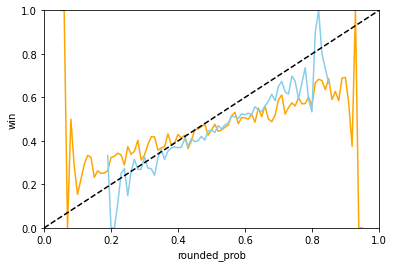

In [118]:
matchups['rounded_prob'] = round(matchups['win_probability'],2)
grouped_df = matchups.groupby('rounded_prob').mean().reset_index()

matchups['rounded_implied_odds'] = round(matchups['implied_odds'],2)
grouped_df_2 = matchups.groupby('rounded_implied_odds').mean().reset_index()


sns.lineplot(x="rounded_prob", y='win', data = grouped_df,color='orange')
sns.lineplot(x="rounded_implied_odds", y='win', data = grouped_df_2,color='skyblue')
plt.plot([0,1],[0,1], color='black', linestyle= 'dashed')
plt.xlim([0,1])
plt.ylim([0,1])


In [119]:
# setting up dataframe with results only
metric_df = matchups.copy()
metric_df["binary_win_probability"] = round(metric_df['win_probability'], 0)

# drop null and inf values
metric_df = metric_df[metric_df.notnull().all(axis=1)]

# calculating standard metrics for lumpy awards
fpr, tpr, thresholds = roc_curve(
    metric_df["win"], metric_df["win_probability"], pos_label=True
)
areacurve = auc(fpr, tpr)
brierscorebinary = brier_score_loss(
    metric_df["win"], metric_df["win_probability"]
)
f1 = f1_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)
loglossbinary = log_loss(metric_df["win"], metric_df["win_probability"])
precision = precision_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)
recall = recall_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)

print('Results for BARB')
print('auc ',areacurve)
print('brier_score ',brierscorebinary)
print('f1_score ',f1)
print('log_loss ',loglossbinary)
print('precision ',precision)
print('recall ',recall)

Results for BARB
auc  0.6096643518518519
brier_score  0.24211690165996022
f1_score  0.5939232992267437
log_loss  0.6754739371293
precision  0.5959867523865185
recall  0.5932203389830508


In [120]:
# setting up dataframe with results only
metric_df = matchups.copy()
metric_df["binary_win_probability"] = round(metric_df['implied_odds'], 0)

# drop null and inf values
metric_df = metric_df[metric_df.notnull().all(axis=1)]

# calculating standard metrics for lumpy awards
fpr, tpr, thresholds = roc_curve(
    metric_df["win"], metric_df["implied_odds"], pos_label=True
)
areacurve = auc(fpr, tpr)
brierscorebinary = brier_score_loss(
    metric_df["win"], metric_df["implied_odds"]
)
f1 = f1_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)
loglossbinary = log_loss(metric_df["win"], metric_df["implied_odds"])
precision = precision_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)
recall = recall_score(
    metric_df["win"], metric_df["binary_win_probability"], average="weighted"
)

print('Results for Bookmakers')
print('auc ',areacurve)
print('brier_score ',brierscorebinary)
print('f1_score ',f1)
print('log_loss ',loglossbinary)
print('precision ',precision)
print('recall ',recall)

Results for Bookmakers
auc  0.6179108796296297
brier_score  0.24079975121872174
f1_score  0.6005785732991468
log_loss  0.6742851787219737
precision  0.6143013744835146
recall  0.6016949152542372


In [121]:
#isolating for the sides of the bets that I would make

bets_df = matchups.loc[matchups['win_probability'] > matchups['implied_odds']]
bets_df.head(100)

,Date_x,Tm_team,Home_Away,Opp,W/L,R,RA,Inn,W-L,Rank,...,teams_games_team,Tm_opponent,PT_opponent,teams_games_opponent,team_wins,team_loses,win_probability,win,rounded_prob,rounded_implied_odds
41,"Friday, May 21",MIN,Home,MIL,W,15.0,3.0,9.0,25-17,1.0,...,42,MIL,0.386680,42,0.356408,0.161976,0.687537,1,0.69,0.64
42,"Saturday, May 22",MIN,Home,MIL,W-wo,8.0,7.0,12.0,26-17,1.0,...,43,MIL,0.449817,43,0.288486,0.213958,0.574165,0,0.57,0.56
43,"Sunday, May 23",MIN,Home,MIL,L,3.0,4.0,9.0,26-18,1.0,...,44,MIL,0.380175,44,0.364526,0.156590,0.699511,0,0.70,0.64
47,"Friday, May 28",MIN,Home,TEX,W,2.0,1.0,9.0,28-20,1.0,...,48,TEX,0.463210,48,0.288286,0.214441,0.573445,1,0.57,0.56
48,"Saturday, May 29",MIN,Home,TEX,W,8.0,3.0,9.0,29-20,1.0,...,49,TEX,0.469661,49,0.280045,0.221657,0.558189,1,0.56,0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,"Saturday, Aug 17",MIN,Home,CHW,L,5.0,8.0,9.0,54-67,4.0,...,631,CHW,0.489641,632,0.251947,0.247922,0.504026,0,0.50,0.48
679,"Sunday, Aug 18",MIN,Home,CHW,L,2.0,5.0,9.0,54-68,4.0,...,632,CHW,0.418555,633,0.328660,0.181968,0.643639,0,0.64,0.57
680,"Monday, Aug 19",MIN,Home,NYM,L,1.0,6.0,9.0,54-69,4.0,...,633,NYM,0.462652,633,0.305044,0.200012,0.603981,0,0.60,0.57
706,"Monday, Sep 16",MIN,@,CHW,L,1.0,12.0,9.0,64-85,4.0,...,659,CHW,0.468527,660,0.266187,0.233866,0.532317,0,0.53,0.50


In [122]:
bets_df['advantage'] = bets_df['rounded_prob'] - bets_df['rounded_implied_odds']
bets_df['advantage_prop'] = bets_df['advantage'] / .15
bets_df['advantage_prop'][bets_df['advantage_prop'] > 1] = 1

/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/miniconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:/

In [123]:
# dates = dates.astype('datetime64')
bets_df = bets_df.sort_values(['Date_x','season']).reset_index()
dates = bets_df['Date_y']
dates

0        4/10/2015
1        4/10/2015
2        4/10/2015
3        4/10/2015
4        4/10/2015
           ...    
14299    9/30/2015
14300    9/30/2015
14301    9/30/2015
14302    9/30/2015
14303    9/30/2015
Name: Date_y, Length: 14304, dtype: object

In [128]:
fund = 1000
max_wager = 0.02
payouts = []

#build a dateloop

for index, row in bets_df.iterrows():
    #determining how much to bet
    if row['Close'] < 0:
        principal = row['advantage_prop'] * max_wager * fund
        winning_payout = (-100 / row['Close']) * principal
    else:
        principal = (((max_wager*2) * fund) * row['advantage_prop'] * 100) / row['Close']
        winning_payout = (row['Close'] / 100) * principal
    #payout
    if row['win'] == 1:
        result = winning_payout
    else:
        result = -1 * principal
        
    #logging results
    payouts.append(result)
    fund = fund + result
    print(fund)
    
    
print(np.mean(bets_df['win']))

980.0
976.08
956.5584
951.9623236036036
944.3466250147748
947.7496759157289
950.2770083848375
936.3396122618599
938.8365178945581
922.5633515843858
918.6270812842924
916.1774090675343
913.7342693100209
921.0233176122091
919.7952865220595
906.0733987977211
904.8653009326574
903.6588138647472
904.6150665778316
907.5569041927189
911.5637779419142
907.9175228301465
904.285852738826
897.6336349715518
888.058876198522
879.037325710156
874.3491266397018
880.5944775442711
890.8042685882626
898.0339843912978
895.6392270995877
894.4450414634549
892.0598546862191
889.6810284070558
899.170959376731
901.0891907567348
905.4422786347866
912.6858168638649
902.9505014839838
900.5426334800264
902.4637910981172
904.1234946219759
896.8905066650001
903.1297449722349
907.4303628054361
921.949248610323
918.2614516158817
923.3629041248588
913.5136998141936
918.2902420354443
913.392694077922
899.9850948987965
901.4850700569613
903.8890302437799
905.517659127102
895.8588040964129
895.8588040964129
893.539428551